# Motivation



*   Build an End-2-End Model
*   Classification or Regression
*   Feature Importance ?
*   Probability Calibration?
 



# Load Libraries

In [ ]:
!pip install blackcellmagic
!pip install ipython-autotime
!pip install swifter

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import swifter
import warnings
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import RobustScaler

In [ ]:
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 999)
pd.set_option('display.max_columns', 999)
pd.set_option("display.max_rows", 999)

# Utilities 

# Load Data

In [ ]:
data = pd.read_csv("/content/UNSW_NB15_testing-set.csv")
display(data.shape)
display(data.head())

(175341, 45)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0


1    68.062233
0    31.937767
Name: label, dtype: float64

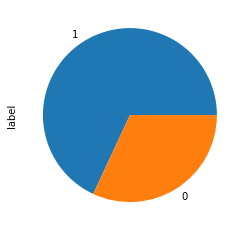

In [ ]:
display(data.label.value_counts(dropna=False,normalize=True)*100)
(data.label.value_counts(dropna=False,normalize=True)*100).plot(kind='pie')

# Exploratory Data Analysis

## Data Types

In [ ]:
data.dtypes.value_counts(dropna=False,normalize=True)*100

int64      66.666667
float64    24.444444
object      8.888889
dtype: float64

In [ ]:
data.select_dtypes(include='float').head()

,dur,rate,sload,dload,sinpkt,dinpkt,sjit,djit,tcprtt,synack,ackdat
0,0.121478,74.087490,14158.942380,8495.365234,24.295600,8.375000,30.177547,11.830604,0.000000,0.000000,0.000000
1,0.649902,78.473372,8395.112305,503571.312500,49.915000,15.432865,61.426934,1387.778330,0.000000,0.000000,0.000000
2,1.623129,14.170161,1572.271851,60929.230470,231.875571,102.737203,17179.586860,11420.926230,0.111897,0.061458,0.050439
3,1.681642,13.677108,2740.178955,3358.622070,152.876547,90.235726,259.080172,4991.784669,0.000000,0.000000,0.000000
4,0.449454,33.373826,8561.499023,3987.059814,47.750333,75.659602,2415.837634,115.807000,0.128381,0.071147,0.057234


## Duplicate Values

In [ ]:
data[data.duplicated()].shape

(0, 45)

## Missing Values

In [ ]:
((data.isnull().sum()/data.shape[0])*100).loc[lambda x : x>0.0]

Series([], dtype: float64)

## Zero-Variance

In [ ]:
data.fillna(-999).nunique().loc[lambda x: x>1]

id                   175341
dur                   74039
proto                   133
service                  13
state                     9
spkts                   480
dpkts                   443
sbytes                 7214
dbytes                 6660
rate                  76991
sttl                     11
dttl                      6
sload                 80885
dload                 77474
sloss                   409
dloss                   370
sinpkt                76161
dinpkt                74245
sjit                  77532
djit                  76831
swin                     13
stcpb                 75265
dtcpb                 75089
dwin                      7
tcprtt                43319
synack                40142
ackdat                37708
smean                  1357
dmean                  1328
trans_depth              11
response_body_len      2386
ct_srv_src               52
ct_state_ttl              5
ct_dst_ltm               50
ct_src_dport_ltm         47
ct_dst_sport_ltm    

## Drop Columns

In [ ]:
data.drop(labels=['id','attack_cat'],axis=1,inplace=True)

# Exploratory Data Analysis

## Bi-Variate Analysis

In [ ]:
pd.crosstab(data.proto,data.label,dropna=False,normalize=True).sort_values(by=1,ascending=False)[:10]*100

label,0,1
proto,,
udp,7.939957,28.151431
tcp,22.311382,23.283202
unas,0.000000,6.891714
ospf,0.036500,1.443473
sctp,0.000000,0.655865
any,0.000000,0.171095
gre,0.000000,0.128321
sun-nd,0.000000,0.114634
swipe,0.000000,0.114634


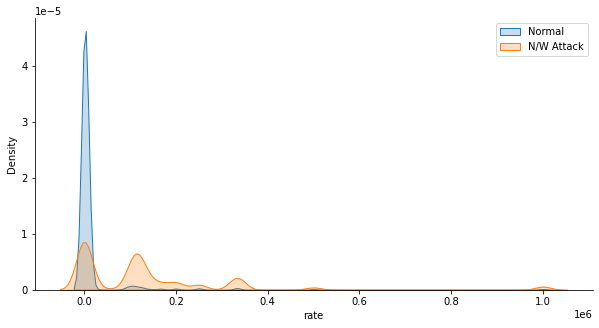

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)
sns.kdeplot(data[data.label==0]['rate'], shade=True)
sns.kdeplot(data[data.label==1]['rate'], shade=True)
plt.legend(['Normal','N/W Attack'])
plt.show()
del f,ax

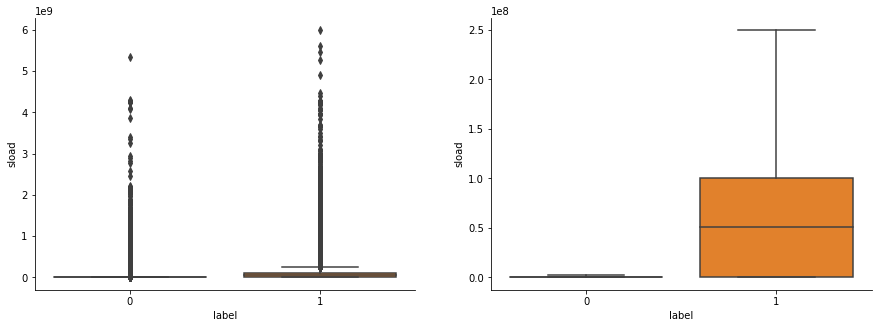

In [ ]:
fig,axarr = plt.subplots(1,2,figsize=(15,5))
sns.despine(fig)
sns.boxplot(y='sload',x='label',data=data,showfliers=True,ax=axarr[0])
sns.boxplot(y='sload',x='label',data=data,showfliers=False,ax=axarr[1])
plt.close(2)
plt.close(3)
del fig,axarr

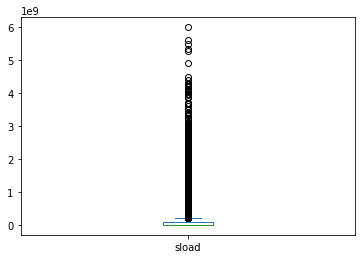

In [ ]:
data.sload.plot.box()

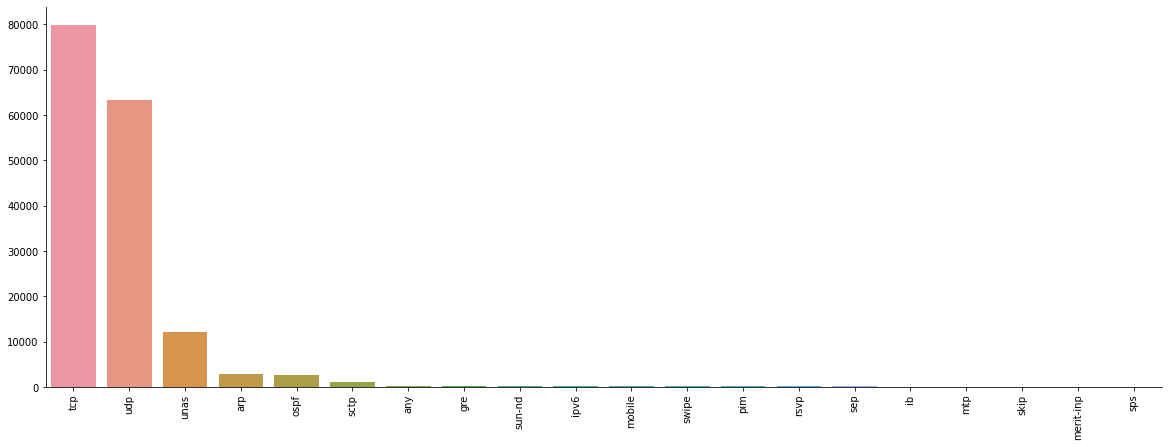

In [ ]:
plt.figure(figsize=(20, 7))
plt.xticks(rotation=90)
sns.despine()
sns.barplot(x=data['proto'].value_counts().index[:20],y=data['proto'].value_counts().values[:20])

In [ ]:
#data_airport['Detection Time'] = data_airport['Detection Time'].astype('datetime64[ns]')

Dask Apply:   0%|          | 0/4 [00:00<?, ?it/s]

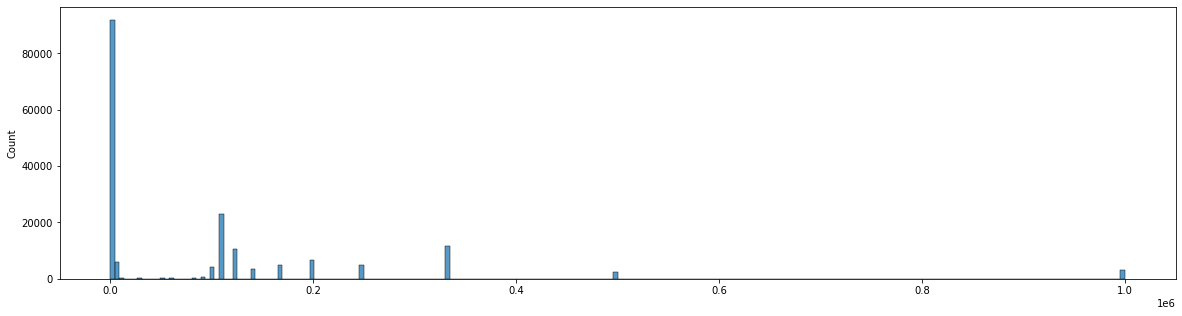

In [ ]:
plt.figure(figsize=(20, 5))
sns.despine()
sns.histplot(data[['dur', 'rate'
                           ]].swifter.apply(lambda x: abs(x[0] - x[1]),
                                            axis=1))

# Sampling : Train Vs OOT

In [ ]:
train, test, Y_train, Y_test = train_test_split(
    data[data.columns[:-1]],
    data.label,
    test_size=0.1,
    random_state=9,
    stratify=data.label)

In [ ]:
display(train.shape)
train['label'] = Y_train.copy(deep=True)
display(test.shape)
test['label'] = Y_test.copy(deep=True)
display(train.head())
display(test.head())
del Y_train,Y_test

(157806, 42)

(17535, 42)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
98061,59.760056,ospf,-,INT,180,0,48960,0,2.995312,254,0,6.517798e+03,0.00000,0,0,333.854969,0.000000,403.300313,0.000000,0,0,0,0,0.000000,0.000000,0.0000,272,0,0,0,1,2,2,1,1,4,0,0,0,24,1,0,1
86175,0.346701,tcp,-,FIN,10,6,782,268,43.264946,254,252,1.624454e+04,5168.71875,2,1,38.410889,60.816801,2128.389648,98.789359,255,3859279894,3743562316,255,0.067208,0.042608,0.0246,78,45,0,0,10,1,1,1,1,8,0,0,0,1,9,0,0
123511,0.000010,udp,-,INT,2,0,1064,0,100000.002500,254,0,4.256000e+08,0.00000,0,0,0.010000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.0000,532,0,0,0,4,2,2,3,2,2,0,0,0,4,4,0,1
38199,0.001140,udp,dns,CON,2,2,146,178,2631.579064,31,29,5.122807e+05,624561.43750,0,0,0.009000,0.001000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.0000,73,89,0,0,3,0,1,1,1,2,0,0,0,2,2,0,0
71134,0.000003,vrrp,-,INT,2,0,200,0,333333.321500,254,0,2.666667e+08,0.00000,0,0,0.003000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.0000,100,0,0,0,4,2,2,2,2,4,0,0,0,16,4,0,1


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
78829,0.934978,tcp,-,FIN,10,8,564,354,18.182246,254,252,4.346626e+03,2.652469e+03,2,1,103.886444,127.220289,6748.359921,186.543125,255,1015258993,1207998395,255,0.072578,0.043788,0.028790,56,44,0,0,1,1,1,1,1,1,0,0,0,1,1,0,1
131948,0.799981,tcp,http,FIN,10,8,1118,354,21.250505,254,252,1.007024e+04,3.100074e+03,2,1,84.851556,102.830289,4931.722272,166.615281,255,2352341256,3872724003,255,0.173060,0.080168,0.092892,112,44,1,0,2,1,2,2,2,2,0,0,4,4,2,0,1
19142,0.009266,tcp,ssh,FIN,32,26,3728,5578,6151.521532,31,29,3.118498e+06,4.631124e+06,7,7,0.298903,0.344520,19.286669,0.493169,255,413281394,2558920819,255,0.000605,0.000490,0.000115,117,215,0,0,1,0,3,1,1,1,0,0,0,3,1,0,0
171397,0.000005,udp,dns,INT,2,0,114,0,200000.005100,254,0,9.120000e+07,0.000000e+00,0,0,0.005000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,22,2,16,16,16,22,0,0,0,16,22,0,1
132009,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000e+00,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,27,2,17,17,17,27,0,0,0,19,27,0,1


# Feature Engineering

In [ ]:
#data['Detection Time'] = data_airport['Detection Time'].astype('datetime64[ns]')

# Feature Scaling

In [ ]:
X_train = RobustScaler().fit(train).transform(train)
X_test = RobustScaler().fit(train).transform(test)

# Feature Selection

## Duplicate & Null Check

## Correlation

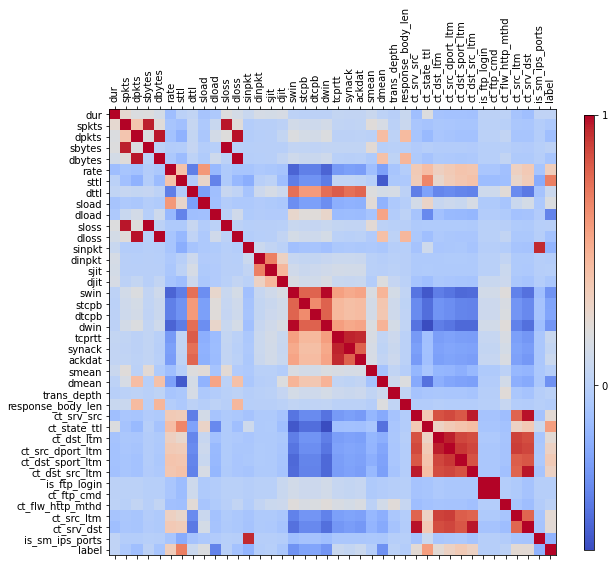

In [ ]:
corr = train.corr()
# Plot the correlation matrix
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(corr, cmap='coolwarm')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
# Add the colorbar legend
cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)
del fig,ax,cax,corr,cbar

In [ ]:
cor_matrix = train[train.columns.tolist()[:-1]].corr().abs()
upper_tri = cor_matrix.where(
    np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
to_drop = [
    column for column in upper_tri.columns if any(upper_tri[column] > 0.90)
]
del cor_matrix, upper_tri

In [ ]:
to_drop

['sbytes',
 'dbytes',
 'sloss',
 'dloss',
 'dwin',
 'synack',
 'ackdat',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'ct_ftp_cmd',
 'ct_srv_dst',
 'is_sm_ips_ports']

In [ ]:
train.drop(columns=to_drop,inplace=True)

## Zero-Variance

In [ ]:
train.drop(columns=[
    col for col in train.columns if len(train[col].unique()) < 2
],
                inplace=True)

## Infinity Check

In [ ]:
train.select_dtypes('float').columns.to_series()[np.isinf(train.select_dtypes('float')).any()]

Series([], dtype: object)

# Model Fit

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(
    penalty='l1',
    dual=False,
    tol=0.01,
    C=0.9,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight={
        0: 0.3,
        1: 0.7
    },
    random_state=9,
    solver='liblinear',
    max_iter=10,
    multi_class='auto',
    verbose=1,
    warm_start=True,
    n_jobs=-1,
    l1_ratio=None,
).fit(X_train, Y_train)

# Evaluate Model

In [ ]:
print(
    metrics.classification_report(
        Y_test, np.where(lr.predict_proba(X_test)[:, 1] > 0.0, 1, 0)))

# Model Feature Explain

In [ ]:
len(lr.coef_[0])
lr.coef_[0]
lr.intercept_
[x for x in zip(lr.coef_[0],train.columns[:-1]) if x[0]!=0]

In [ ]:
from scipy.stats.kde import exp
exp(0.82)

2.2704998375324057